# Noise and disambiguation

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation
from connectivity_functions import get_weights_from_probabilities, get_probabilities_from_network_representation
from connectivity_functions import create_matrix_from_sequences_representation, produce_overlaped_sequences
from analysis_functions import calculate_recall_time_quantities, get_weights
from analysis_functions import get_weights_collections
from plotting_functions import plot_network_activity_angle, plot_weight_matrix
from analysis_functions import calculate_angle_from_history, calculate_winning_pattern_from_distances
from analysis_functions import calculate_patterns_timings, calculate_recall_success_nr

epsilon = 10e-80

## An example

s1=  1.0


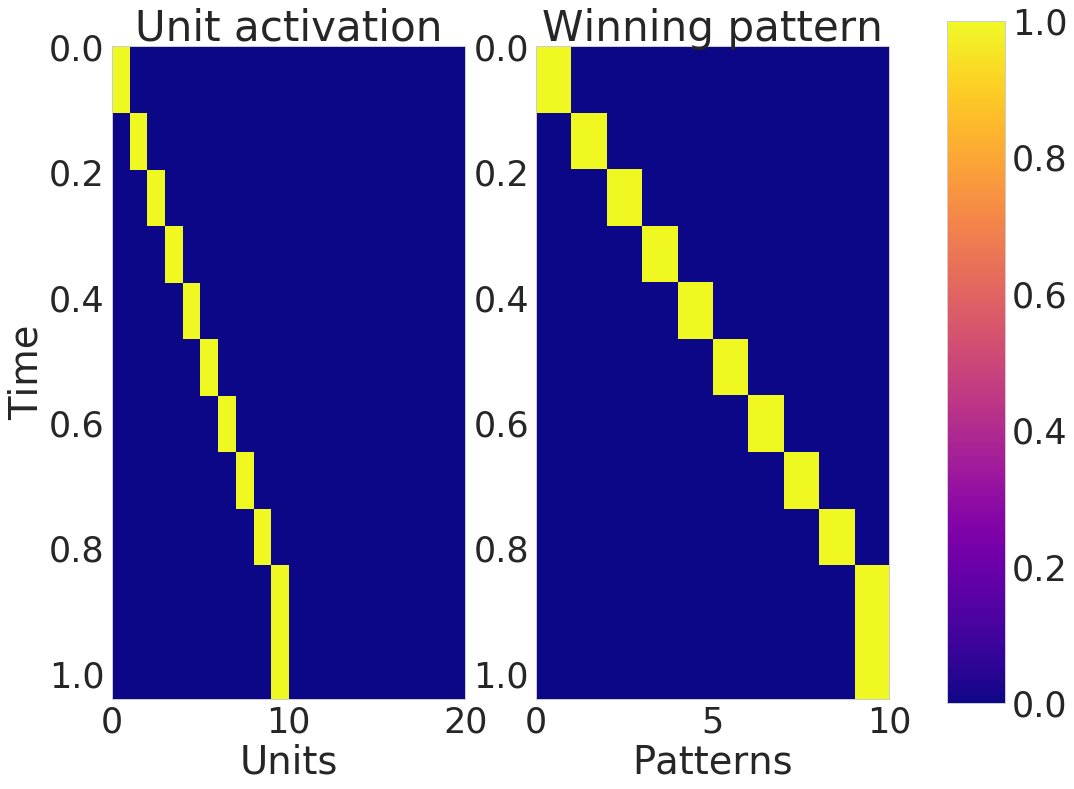

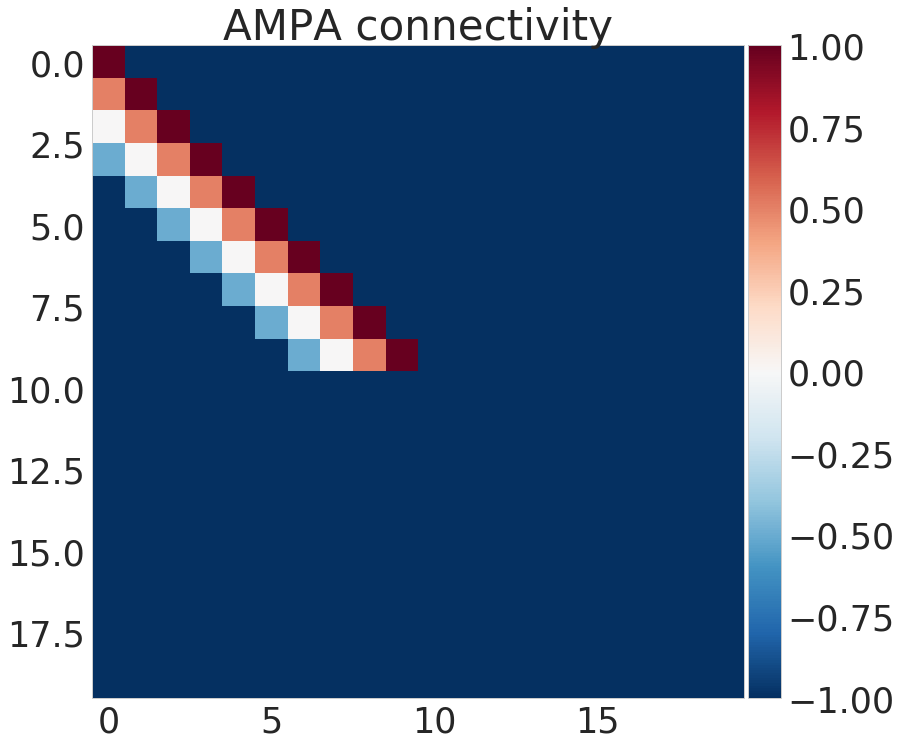

In [4]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.100
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'i_ampa', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0

# Recall
T_cue = 0.020
T_recall = 1.0 + T_cue
n = 1


# Neural Network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
seq = matrix[:n_patterns]
nr = build_network_representation(seq, minicolumns, hypercolumns)

n_connections = len(seq) - 1
value = 1.0
extension = 3
alpha = 0.5
w_min = -10
weights = [value for i in range(n_connections)]
weights_collection = [weights]
sequences = [seq]
w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                extension, alpha, w_min=w_min)

nn.w_ampa = w
aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
manager.patterns_dic = patterns_dic

aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=0.020)
s, timings, pattern_sequence = aux
print('s1= ', s)
plot_network_activity_angle(manager)
plot_weight_matrix(nn, ampa=True)

## A disambiguation example

In [91]:
%%time
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.100
G = 1.0
sigma = 0.5
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'i_ampa', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0

# Recall
T_cue = 0.020
T_recall = 1.0 + T_cue
n = 1

# Build the protocol for training
mixed_start = False
contiguous = True
s = 1.0
r = 0.2
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
seq1, seq2 = produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r,
                                         mixed_start=mixed_start, contiguous=contiguous)

nr1 = build_network_representation(seq1, minicolumns, hypercolumns)
nr2 = build_network_representation(seq2, minicolumns, hypercolumns)
n_connections = len(seq1) - 1
value = 1.0
extension = 3
alpha = 0.5
weights = [value for i in range(n_connections)]
weights_collection = [weights, weights]
sequences = [seq1, seq2]

w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                extension, alpha, w_min=-1.0)
# Neural Network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

nn.w_ampa = w
nr = np.concatenate((nr1, nr2))
aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
manager.patterns_dic = patterns_dic

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 919 µs


s1=  1.0
s2=  1.0


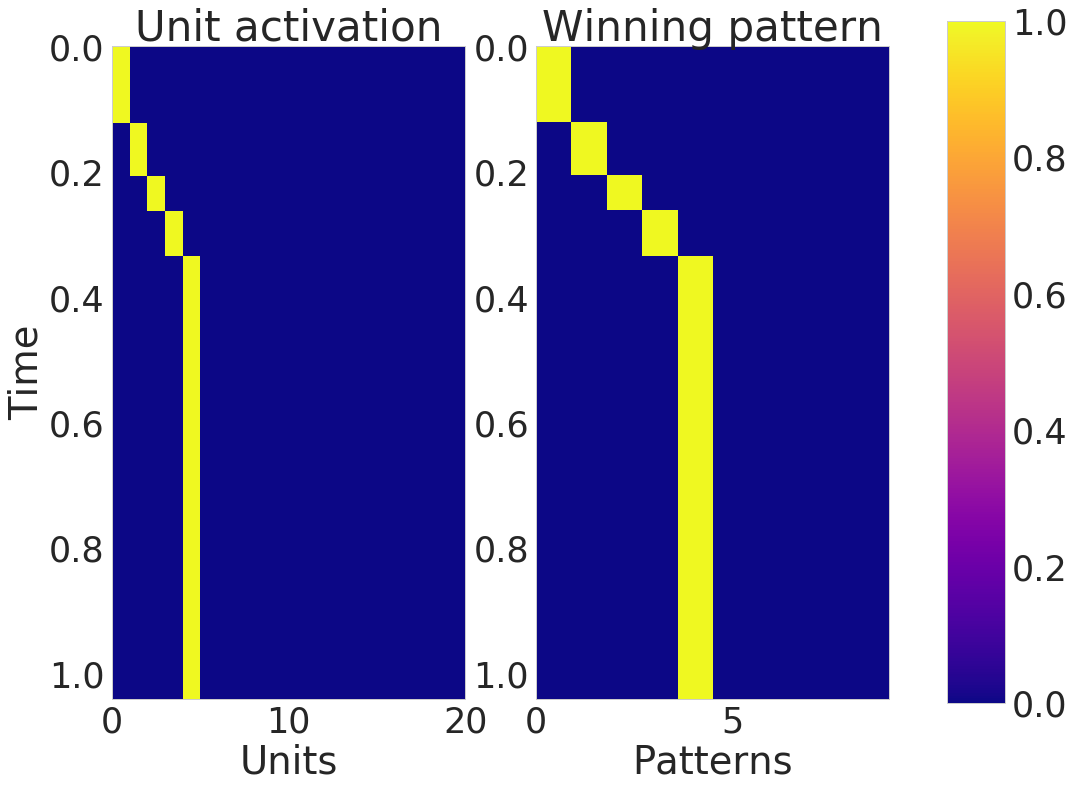

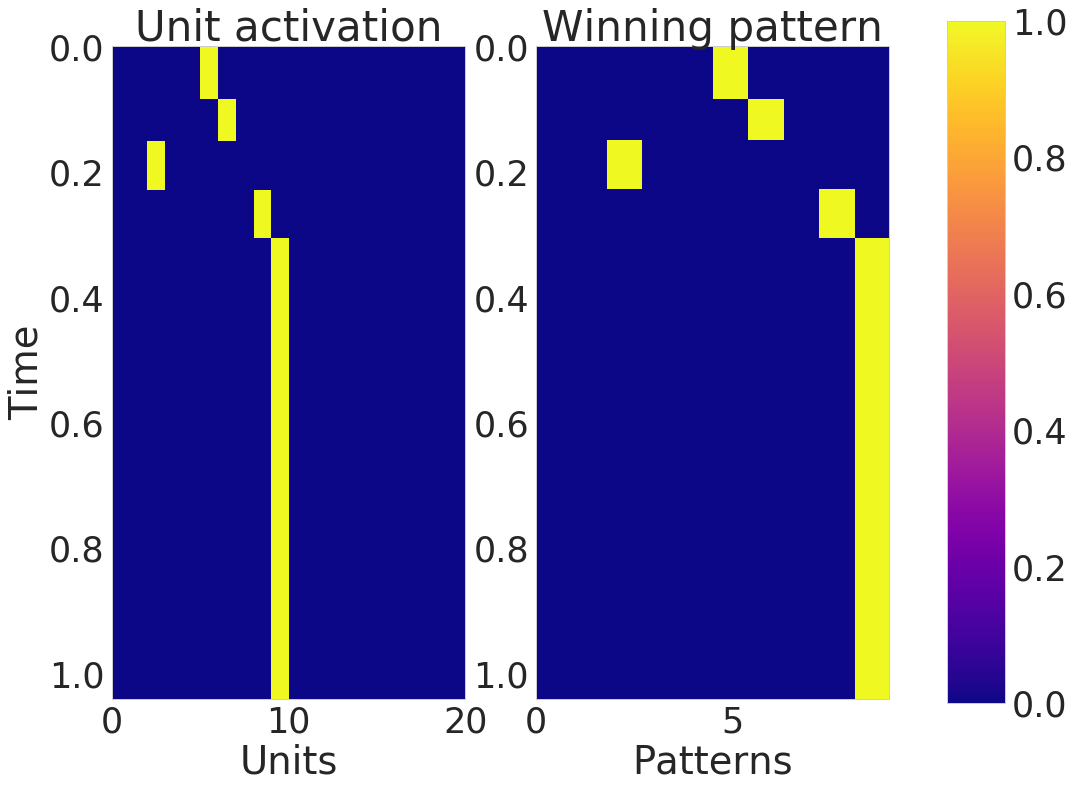

In [92]:
aux = calculate_recall_success_nr(manager, nr1, T_recall, T_cue, debug=True, remove=0.010)
s, timings, pattern_sequence = aux
print('s1= ', s)
plot_network_activity_angle(manager)

aux = calculate_recall_success_nr(manager, nr2, T_recall, T_cue, debug=True, remove=0.010)
s, timings, pattern_sequence = aux
print('s2= ', s)
plot_network_activity_angle(manager)

## Noise systematic

In [62]:
%%time
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.100
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'i_ampa', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0

# Recall
T_cue = 0.020
T_recall = 1.0 + T_cue
n = 1

# Protocol
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
seq = matrix[:n_patterns]
nr = build_network_representation(seq, minicolumns, hypercolumns)

n_connections = len(seq) - 1
value = 1.0
extension = 3
alpha = 0.5
weights = [value for i in range(n_connections)]
weights_collection = [weights]
sequences = [seq]
w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                extension, alpha, w_min=-1.0)

# Neural Network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)


nn.w_ampa = w
aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
manager.patterns_dic = patterns_dic

num = 30
trials = 25
sigma_vector = np.linspace(0, 2.0, num=num)
successes = np.zeros((num, trials))
persistence_times = np.zeros((num, trials, n_patterns - 2))


for sigma_index, sigma in enumerate(sigma_vector):
    for trial_index in range(trials):
        nn.sigma = sigma
        aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=0.020)
        s, timings, pattern_sequence = aux
        T_persistence = [t[1] for t in timings[1:-1]]
        successes[sigma_index, trial_index] = s
        n_aux = min((len(T_persistence), n_patterns - 2))
        persistence_times[sigma_index, trial_index, :n_aux] = np.array(T_persistence)[:n_aux]

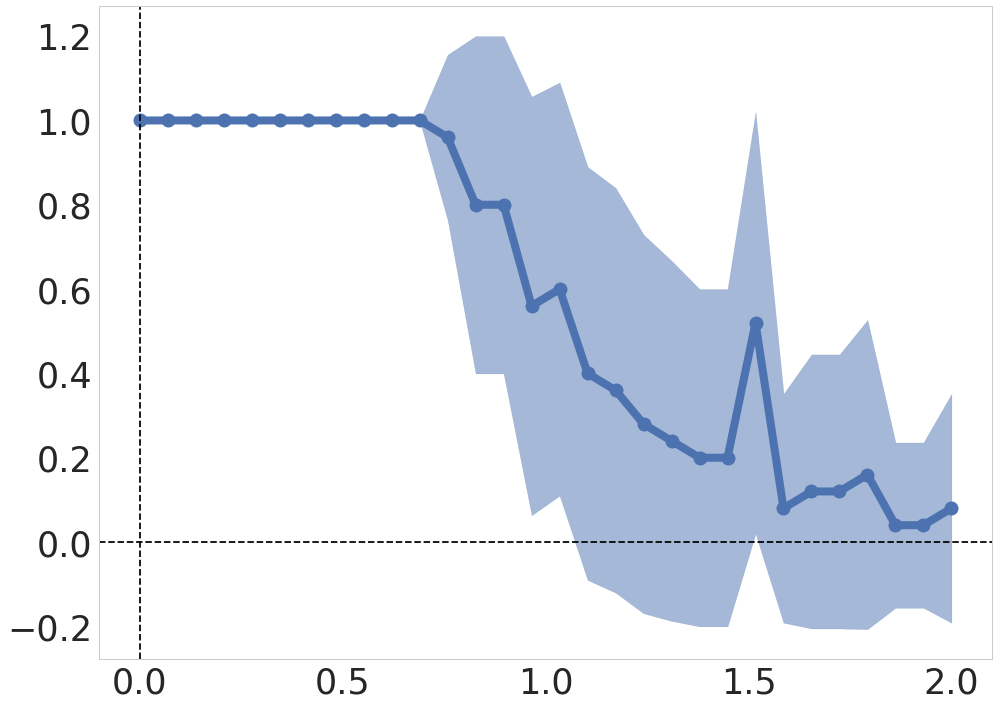

In [63]:
current_palette = sns.color_palette()
index = 0
ms = 14
lw = 8

mean_success = np.mean(successes, axis=1)
std = np.std(successes, axis=1)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(sigma_vector, mean_success, 'o-', color=current_palette[index], lw=lw, ms=ms)
ax.fill_between(sigma_vector, mean_success - std, mean_success + std,
                color=current_palette[index], alpha=alpha)

ax.axhline(0, ls='--', color='black')
ax.axvline(0, ls='--', color='black');

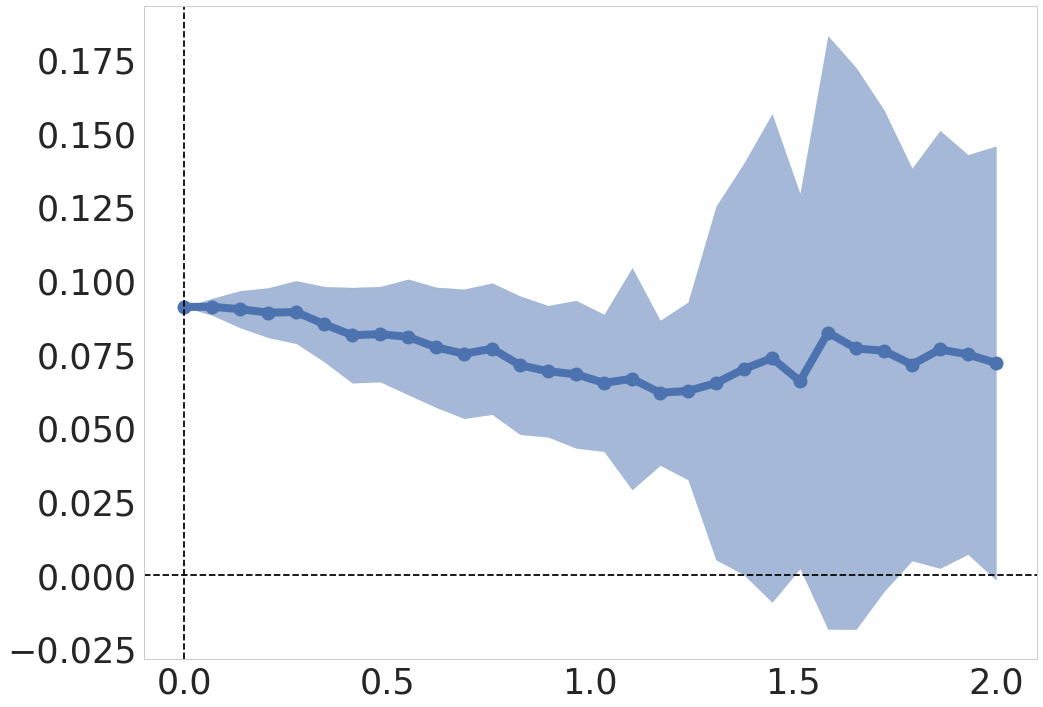

In [66]:
persistence_times_m = np.ma.masked_less_equal(persistence_times, 0.0)

pt_mean = np.mean(persistence_times_m, axis=(1, 2))
pt_std = np.std(persistence_times_m, axis=(1, 2))

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(sigma_vector, pt_mean, 'o-', color=current_palette[index], lw=lw, ms=ms)
ax.fill_between(sigma_vector, pt_mean - pt_std, pt_mean + pt_std,
                color=current_palette[index], alpha=alpha);

ax.axhline(0, ls='--', color='black')
ax.axvline(0, ls='--', color='black');

## Benefits to scale

In [109]:
%%time
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.100
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0

# Recall
T_cue = 0.020
T_recall = 1.0 + T_cue
n = 1

num = 25
trials = 10
sigma_vector = np.linspace(0, 2.0, num=num)
successes = np.zeros((num, trials))
persistence_times = np.zeros((num, trials, n_patterns - 2))

successes_list = []
persistence_times_list = []
hypercolumns_list = [1, 10, 50, 100]

for hypercolumns in hypercolumns_list:
    # Protocol
    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
    seq = matrix[:n_patterns]
    nr = build_network_representation(seq, minicolumns, hypercolumns)

    n_connections = len(seq) - 1
    value = 1.0
    extension = 3
    alpha = 0.5
    weights = [value for i in range(n_connections)]
    weights_collection = [weights]
    sequences = [seq]
    w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                    extension, alpha, w_min=-1.0)

    # Neural Network
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    nn.w_ampa = w
    aux, indexes = np.unique(nr, axis=0, return_index=True)
    patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
    manager.patterns_dic = patterns_dic

    for sigma_index, sigma in enumerate(sigma_vector):
        for trial_index in range(trials):
            nn.sigma = sigma
            aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=0.020)
            s, timings, pattern_sequence = aux
            T_persistence = [t[1] for t in timings[1:-1]]
            successes[sigma_index, trial_index] = s
            n_aux = min((len(T_persistence), n_patterns - 2))
            persistence_times[sigma_index, trial_index, :n_aux] = np.array(T_persistence)[:n_aux]
            
    successes_list.append(np.copy(successes))
    persistence_times_list.append(np.copy(persistence_times))

CPU times: user 1d 7min 35s, sys: 2h 27min 2s, total: 1d 2h 34min 37s
Wall time: 6h 40min 39s


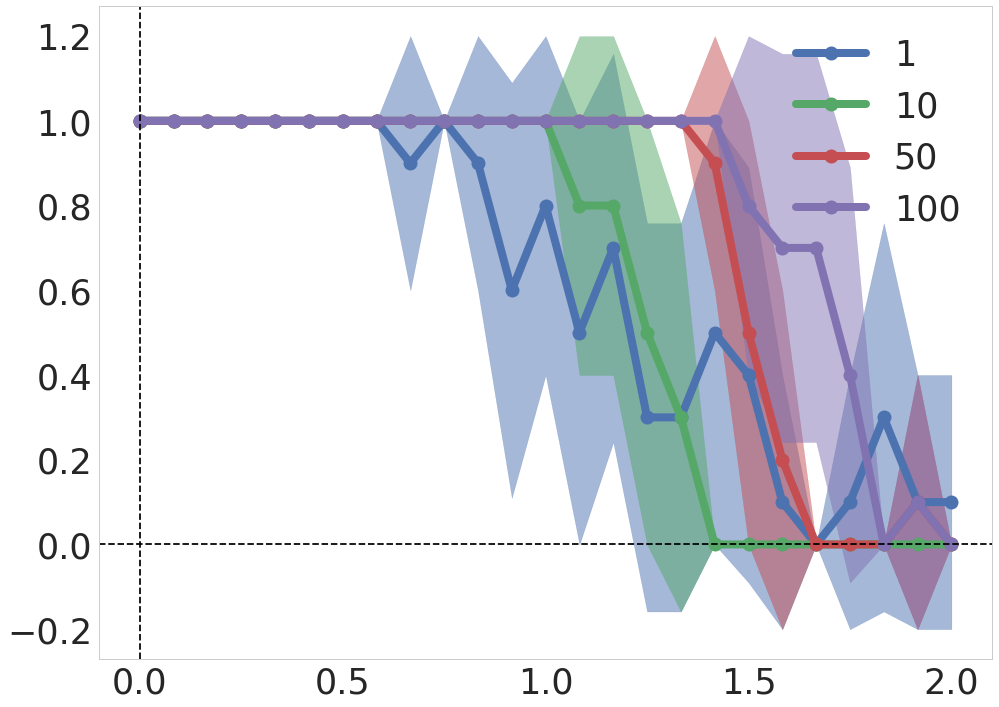

In [111]:
current_palette = sns.color_palette()
index = 0
ms = 14
lw = 8

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for index, successes in enumerate(successes_list):
    mean_success = np.mean(successes, axis=1)
    std = np.std(successes, axis=1)
    ax.plot(sigma_vector, mean_success, 'o-', color=current_palette[index], 
            lw=lw, ms=ms, label=str(hypercolumns_list[index]))
    ax.fill_between(sigma_vector, mean_success - std, mean_success + std,
                    color=current_palette[index], alpha=alpha)

ax.axhline(0, ls='--', color='black')
ax.axvline(0, ls='--', color='black')
ax.legend();

In [ ]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for index, persistence_times in enumerate(persistence_times_list):
    persistence_times_m = np.ma.masked_less_equal(persistence_times, 0.0)

    pt_mean = np.mean(persistence_times_m, axis=(1, 2))
    pt_std = np.std(persistence_times_m, axis=(1, 2))


    ax.plot(sigma_vector, pt_mean, 'o-', color=current_palette[index], lw=lw, ms=ms)
    ax.fill_between(sigma_vector, pt_mean - pt_std, pt_mean + pt_std,
                    color=current_palette[index], alpha=alpha);

    ax.axhline(0, ls='--', color='black')
    ax.axvline(0, ls='--', color='black');

## Disambiguation noise

In [123]:
%%time
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.100
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 20
n_patterns = 20

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'i_ampa', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0

# Recall
T_cue = 0.020
T_recall = 1.0 + T_cue
n = 1

# Build the protocol for training
mixed_start = False
contiguous = True
s = 1.0
r = 0.2
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
seq1, seq2 = produce_overlaped_sequences(minicolumns, hypercolumns, n_patterns, s, r,
                                         mixed_start=mixed_start, contiguous=contiguous)

nr1 = build_network_representation(seq1, minicolumns, hypercolumns)
nr2 = build_network_representation(seq2, minicolumns, hypercolumns)
n_connections = len(seq1) - 1
value = 1.0
extension = 3
alpha = 0.5
weights = [value for i in range(n_connections)]
weights_collection = [weights, weights]
sequences = [seq1, seq2]

w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                extension, alpha, w_min=-10.0)
# Neural Network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

nn.w_ampa = w
nr = np.concatenate((nr1, nr2))
aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
manager.patterns_dic = patterns_dic

num = 20
trials = 5
sigma_vector = np.linspace(0, 1.0, num=num)
successes = np.zeros((num, trials))
successes1 = np.zeros((num, trials))
successes2 = np.zeros((num, trials))

persistence_times = np.zeros((num, trials, n_patterns - 2))

for sigma_index, sigma in enumerate(sigma_vector):
    print(sigma)
    for trial_index in range(trials):
        nn.sigma = sigma
        aux = calculate_recall_success_nr(manager, nr1, T_recall, T_cue, debug=True, remove=0.010)
        s1, timings, pattern_sequence = aux
        aux = calculate_recall_success_nr(manager, nr2, T_recall, T_cue, debug=True, remove=0.010)
        s2, timings, pattern_sequence = aux
        T_persistence = [t[1] for t in timings[1:-1]]
        successes[sigma_index, trial_index] = 0.5 * (s1 + s2)
        successes1[sigma_index, trial_index] = s1
        successes2[sigma_index, trial_index] = s2
        n_aux = min((len(T_persistence), n_patterns - 2))
        persistence_times[sigma_index, trial_index, :n_aux] = np.array(T_persistence)[:n_aux]

0.0
0.0526315789474
0.105263157895
0.157894736842
0.210526315789
0.263157894737
0.315789473684
0.368421052632
0.421052631579
0.473684210526
0.526315789474
0.578947368421
0.631578947368
0.684210526316
0.736842105263
0.789473684211
0.842105263158
0.894736842105
0.947368421053
1.0
CPU times: user 1min 2s, sys: 16 ms, total: 1min 2s
Wall time: 1min 2s


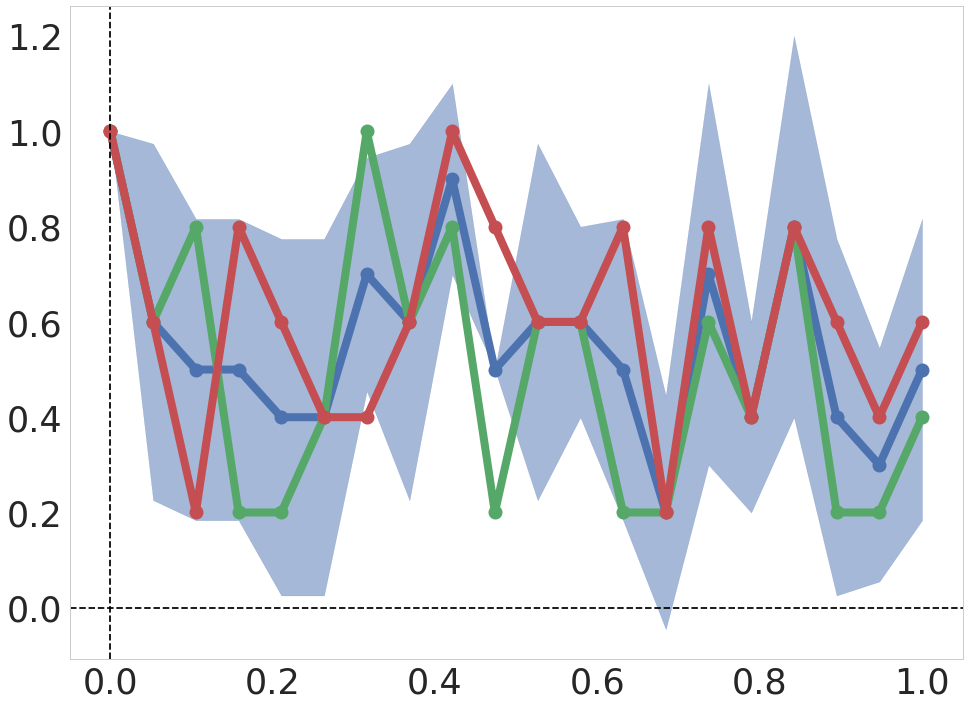

In [126]:
current_palette = sns.color_palette()
index = 0
ms = 14
lw = 8

mean_success = np.mean(successes, axis=1)
mean_success1 = np.mean(successes1, axis=1)
mean_success2 = np.mean(successes2, axis=1)

std = np.std(successes, axis=1)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(sigma_vector, mean_success, 'o-', color=current_palette[index], lw=lw, ms=ms)
ax.plot(sigma_vector, mean_success1, 'o-', color=current_palette[index + 1], lw=lw, ms=ms)
ax.plot(sigma_vector, mean_success2, 'o-', color=current_palette[index + 2], lw=lw, ms=ms)
ax.fill_between(sigma_vector, mean_success - std, mean_success + std,
                color=current_palette[index], alpha=alpha)

ax.axhline(0, ls='--', color='black')
ax.axvline(0, ls='--', color='black');

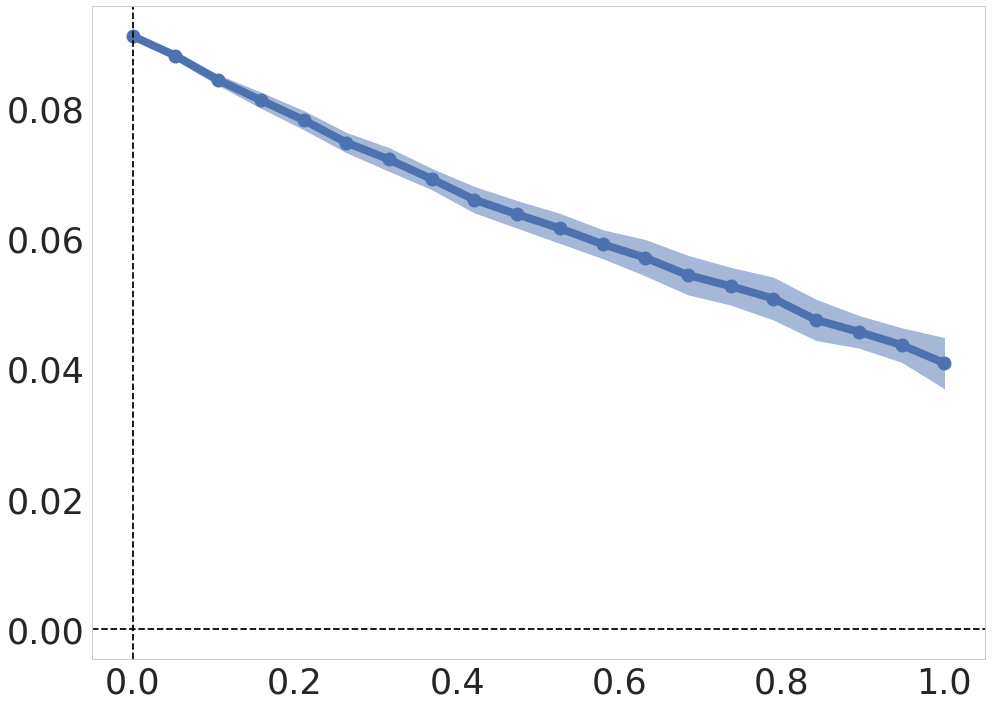

In [122]:
persistence_times_m = np.ma.masked_less_equal(persistence_times, 0.0)

pt_mean = np.mean(persistence_times_m, axis=(1, 2))
pt_std = np.std(persistence_times_m, axis=(1, 2))

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(sigma_vector, pt_mean, 'o-', color=current_palette[index], lw=lw, ms=ms)
ax.fill_between(sigma_vector, pt_mean - pt_std, pt_mean + pt_std,
                color=current_palette[index], alpha=alpha);

ax.axhline(0, ls='--', color='black')
ax.axvline(0, ls='--', color='black');

In [117]:
seq1

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5

In [118]:
seq2

array([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
       [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4, 